## Plot Confidence ellipsoids

In [65]:
import os
import pandas as pd
import numpy  as np
import seaborn as sns
from pathlib   import Path
import matplotlib.pyplot as plt
from IPython.display import Image
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

### Basic confidence intervals
You are a data scientist for a fireworks manufacturer in Des Moines, Iowa. You need to make a case to the city that your company's large fireworks show has not caused any harm to the city's air. To do this, you look at the average levels for pollutants in the week after the $4^{th}$ July and how they compare to readings taken after your last show. By showing confidence intervals around the averages, you can make a case that the recent readings were well within the normal range.

In [7]:
average_ests = pd.DataFrame(data = {'pollutant' : ['CO', 'NO2', 'O3', 'SO2'],
                                 'mean'      : [0.35, 19.02, 0.04, 0.20],
                                 'std_err'   : [0.03, 2.2, 0.001, 0.037],
                                 'y'         : 4*['95% Interval'],
                                 'seen'      : [0.40, 16.00, 0.05, 0.15]})
print(average_ests)

  pollutant   mean  std_err             y   seen
0        CO   0.35    0.030  95% Interval   0.40
1       NO2  19.02    2.200  95% Interval  16.00
2        O3   0.04    0.001  95% Interval   0.05
3       SO2   0.20    0.037  95% Interval   0.15


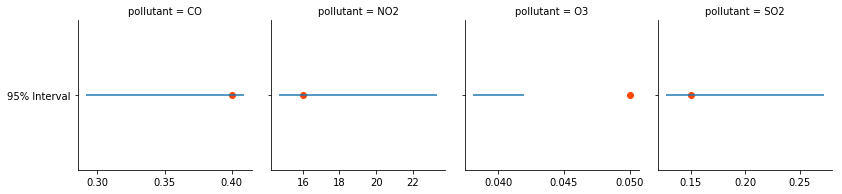

In [78]:
# Construct CI bounds for averages
average_ests['lower'] = average_ests['mean'] - 1.96*average_ests['std_err']
average_ests['upper'] = average_ests['mean'] + 1.96*average_ests['std_err']

# Setup a grid of plots, with non-shared x axes limits
g = sns.FacetGrid(average_ests, col = 'pollutant', sharex = False)

# Plot CI for average estimate
g.map(plt.hlines, 'y', 'lower', 'upper')

# Plot observed values for comparison and remove axes labels
g.map(plt.scatter, 'seen', 'y', color = 'orangered').set_ylabels('').set_xlabels('')

plt.show()

### Annotating confidence intervals
You want to see if the SO2 levels are significantly different in the two cities, and more specifically, which city has lower levels. To test this, you decide to look at the differences in the cities' SO2 values (`Indianapolis` - `Cincinnati`) over multiple years (provided as `diffs_by_year`). Instead of just displaying a p-value for a significant difference between the cities, you decide to look at the 95% confidence intervals (columns lower and upper) of the differences. This allows you to see the magnitude of the differences along with any trends over the years.

In [53]:
np_matrix = np.array([[2013,  0.840820,  0.870135, -0.864645,  2.546284],
                      [2014, -1.337625,  0.761541, -2.830245,  0.154996],
                      [2015, -0.649327,  0.618175, -1.860950,  0.562295]])

diffs_by_year = pd.DataFrame(data = np_matrix,
                            columns = ['year', 'mean', 'std_err', 'lower', 'upper'],
                            index = [0 ,1, 2]) 
diffs_by_year

,year,mean,std_err,lower,upper
0,2013.0,0.840820,0.870135,-0.864645,2.546284
1,2014.0,-1.337625,0.761541,-2.830245,0.154996
2,2015.0,-0.649327,0.618175,-1.860950,0.562295


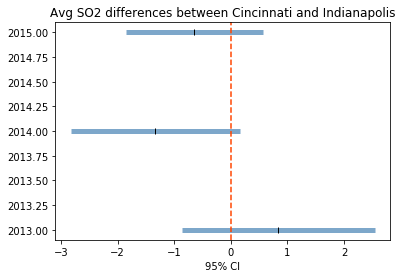

In [14]:
# Set start and ends according to intervals 
# Make lines thicker and transparent
plt.hlines(y = 'year', xmin = 'lower', xmax = 'upper', 
           linewidth = 5, color = 'steelblue', alpha = 0.7,
           data = diffs_by_year)
# Point estimates
plt.plot('mean', 'year', 'k|', data = diffs_by_year)

# Add a 'null' reference line at 0 and color orangered
plt.axvline(x = 0, color = 'orangered', linestyle = '--')

# Set descriptive axis labels and title
plt.xlabel('95% CI')
plt.title('Avg SO2 differences between Cincinnati and Indianapolis')
plt.show()

### Confidence band
`Vandenberg Air Force Base` is often used as a location to launch rockets into space. You have a theory that a recent increase in the pace of rocket launches could be harming the air quality in the surrounding region. To explore this, you plotted a 25-day rolling average line of the measurements of atmospheric NO2. To help decide if any pattern observed is random-noise or not, you decide to add a 99% confidence band around your rolling mean. Adding a confidence band to a trend line can help shed light on the stability of the trend seen. This can either increase or decrease the confidence in the discovered trend. <br>
*Note: we didn't calcutate the rolling mean here*

In [35]:
# set root directory
path_root = Path("C:/Users/giann/data-science-core")
os.chdir(path_root)
print(f'- Root directory = {os.getcwd()}')

- Root directory = C:\Users\giann\data-science-core


In [41]:
# import dataset
path_dataset = path_root / 'dataset/pollution_wide.csv'
pollution  = pd.read_csv(path_dataset)
pollution.head()

,city,year,month,day,CO,NO2,O3,SO2
0,Cincinnati,2012,1,1,0.245,20.0,0.030,4.20
1,Cincinnati,2012,1,2,0.185,9.0,0.025,6.35
2,Cincinnati,2012,1,3,0.335,31.0,0.025,4.25
3,Cincinnati,2012,1,4,0.305,25.0,0.016,17.15
4,Cincinnati,2012,1,5,0.345,21.0,0.016,11.05


In [42]:
vandenberg_NO2 = pollution.loc[pollution['city'] == 'Vandenberg Air Force Base', ['day', 'NO2']] 
vandenberg_NO2.head()

,day,NO2
7463,1,4.0
7464,2,2.0
7465,3,3.0
7466,4,3.0
7467,5,3.0


In [43]:
def std_err(series) :
    return np.std(series) / np.sqrt(len(series))

vandenberg_NO2 = vandenberg_NO2.groupby('day')['NO2'].agg(['mean', std_err])
_ = vandenberg_NO2.reset_index(level = 0, inplace=True)
vandenberg_NO2.head()

,day,mean,std_err
0,1,2.25,0.544862
1,2,1.50,0.250000
2,3,3.50,1.346291
3,4,2.25,0.414578
4,5,3.00,0.612372


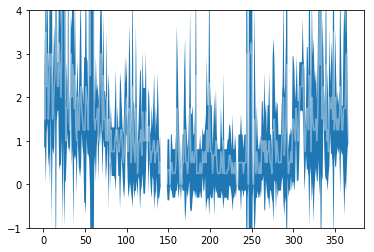

In [47]:
# Draw 99% inverval bands for average NO2
vandenberg_NO2['lower'] = vandenberg_NO2['mean'] - 2.58*vandenberg_NO2['std_err']
vandenberg_NO2['upper'] = vandenberg_NO2['mean'] + 2.58*vandenberg_NO2['std_err']

# Plot mean estimate as a white semi-transparent line
plt.plot('day', 'mean', data = vandenberg_NO2,
         color = 'white', alpha = 0.4)

# Fill between the upper and lower confidence band values
plt.fill_between(x = 'day', y1 = 'lower', y2 = 'upper', 
                 data = vandenberg_NO2)
plt.ylim([-1 , 4])
plt.show()

Below the code to **separate a lot of bands**. `eastern_SO2` is a dataframe with the following columns = [`city  day`, `mean`, `std_err`, `lower`, `upper`]

In [ ]:
# Setup a grid of plots with columns divided by location
g = sns.FacetGrid(eastern_SO2, col = 'city', col_wrap = 2)

# Map interval plots to each cities data with corol colored ribbons
g.map(plt.fill_between, 'day', 'lower', 'upper', color = 'coral')

# Map overlaid mean plots with white line
g.map(plt.plot, 'day', 'mean', color = 'white')

plt.show()

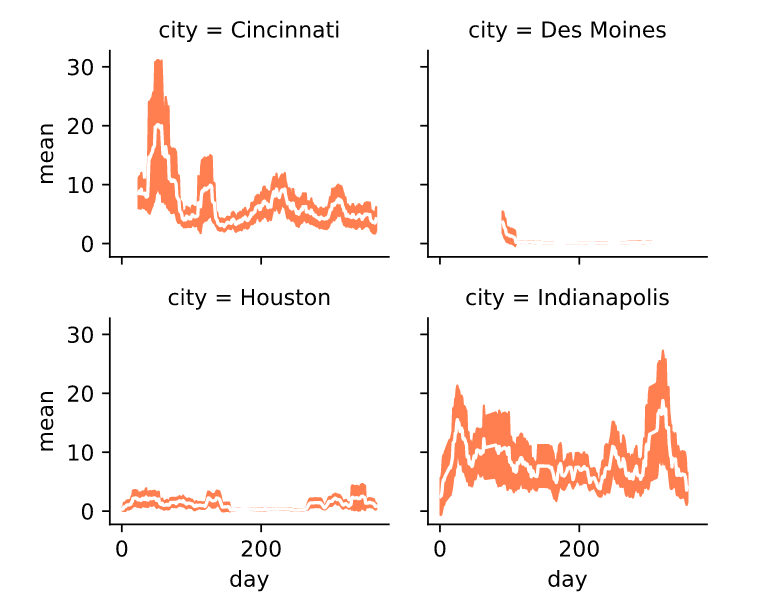

In [50]:
Image(filename = 'plot/time_series_bands.png', width = 500, height = 250)

In [ ]:
# Cleaning up bands for overlaps 
for city, color in [('Denver',"#66c2a5"), ('Long Beach', "#fc8d62")]:
    # Filter data to desired city
    city_data = SO2_compare[SO2_compare.city  ==  city]

    # Set city interval color to desired and lower opacity
    plt.fill_between(x = 'day', y1 = 'lower', y2 = 'upper', data = city_data,
                     color = color, alpha = 0.4 )
    
    # Draw a faint mean line for reference and give a label for legend
    plt.plot('day','mean', data = city_data, label = city,
             color = color, alpha = 0.25)

plt.legend()
plt.show()

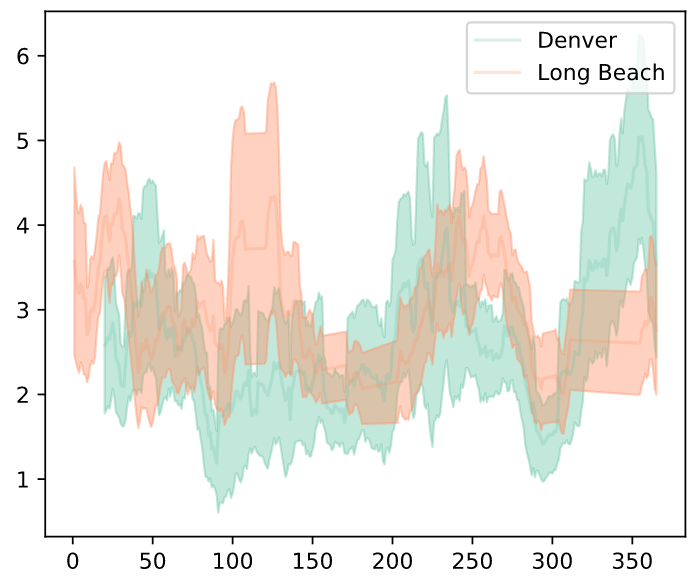

In [51]:
Image(filename = 'plot/time_series_bands_2.png', width = 500, height = 250)

### 90, 95, and 99% intervals
You are a data scientist for an outdoor adventure company in Fairbanks, Alaska. Recently, customers have been having issues with `SO2` pollution, leading to costly cancellations. The company has sensors for `CO`, `NO2`, and `O3` but not `SO2` levels.

In [54]:
# Add interval percent widths
alphas = [     0.01,  0.05,   0.1] 
widths = [ '99% CI', '95%', '90%']
colors = ['#fee08b','#fc8d59','#d53e4f']

In [67]:
data = pd.DataFrame(data = {'pollutant' : ['SO2', 'NO2', 'CO', 'O3'],
                            'est'       : [0.13 , 0.32 , 0.08, 0.56],
                            'std_err'   : [0.034, 0.049, 0.024, 0.022]})
data

,pollutant,est,std_err
0,SO2,0.13,0.034
1,NO2,0.32,0.049
2,CO,0.08,0.024
3,O3,0.56,0.022


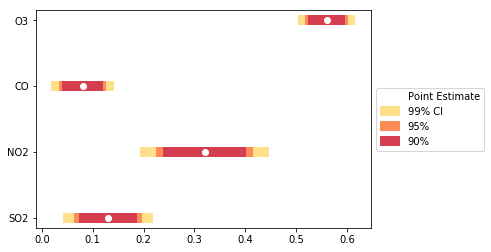

In [73]:
# Add interval percent widths
z_scores = [   2.58, 1.96,  1.67] 
widths   = ['99% CI', '95%', '90%']
colors   = ['#fee08b','#fc8d59','#d53e4f']

for Z, width, color in zip(z_scores, widths, colors):   
    # Pass current interval color and legend label to plot
    plt.hlines(y = data.pollutant, 
               xmin = data['est'] - Z*data['std_err'],
               xmax = data['est'] + Z*data['std_err'],
               colors = color, 
               label = width, 
               linewidth = 10) 

# Draw point estimates
plt.plot('est', 'pollutant', 'wo', data = data, label = 'Point Estimate')
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.show()

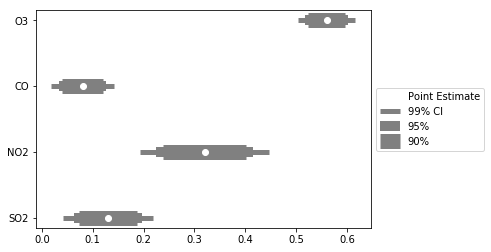

In [75]:
# Decrase interval thickness as interval widens
sizes =      [      5,    10,     15]
int_widths = ['99% CI', '95%', '90%']
z_scores =   [    2.58, 1.96, 1.67 ]

for percent, Z, size in zip(int_widths, z_scores, sizes):
    plt.hlines(y = data.pollutant, 
               xmin = data['est'] - Z*data['std_err'],
               xmax = data['est'] + Z*data['std_err'],
               label = percent, 
               # Resize lines and color them gray
               linewidth = size, 
               color = 'gray') 

# Add point estimate
plt.plot('est', 'pollutant', 'wo', data = data, label = 'Point Estimate')
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.show()

### Visualize bootstrap

In [76]:
# import dataset
path_dataset = path_root / 'dataset/pollution_wide.csv'
pollution  = pd.read_csv(path_dataset)
pollution.head()

,city,year,month,day,CO,NO2,O3,SO2
0,Cincinnati,2012,1,1,0.245,20.0,0.030,4.20
1,Cincinnati,2012,1,2,0.185,9.0,0.025,6.35
2,Cincinnati,2012,1,3,0.335,31.0,0.025,4.25
3,Cincinnati,2012,1,4,0.305,25.0,0.016,17.15
4,Cincinnati,2012,1,5,0.345,21.0,0.016,11.05


In [77]:
cinci_may_NO2 = pollution.query("city  ==  'Cincinnati' & month  ==  5").NO2


# Generate bootstrap samples
boot_means = bootstrap(cinci_may_NO2, 1000)

# Get lower and upper 95% interval bounds
lower, upper = np.percentile(boot_means, [2.5, 97.5])

# Plot shaded area for interval
plt.axvspan(lower, upper, color = 'gray', alpha = 0.2)

# Draw histogram of bootstrap samples
sns.distplot(boot_means, bins = 100, kde = False)

plt.show()

NameError: name 'bootstrap' is not defined